In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

import torch
import pennylane as qml
import torch.nn as nn
import torch.optim as optim
import random

from torch.utils.data import Dataset, DataLoader
from scipy.special import rel_entr

In [2]:
# Set the random seed for reproducibility
seed = 23#23
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
file = h5py.File("/home/reyguadarrama/GSoC/data/quark-gluon_test-set_n139306.hdf5")
jets = file.get('X_jets')[:21000]
label = file.get('y')[:21000]

In [4]:
indices_gluon = np.where(label == 0)[0]

# Datos de la clase 0
jets_gluon = jets[indices_gluon]


In [5]:
jets_gluon.shape

(10519, 125, 125, 3)

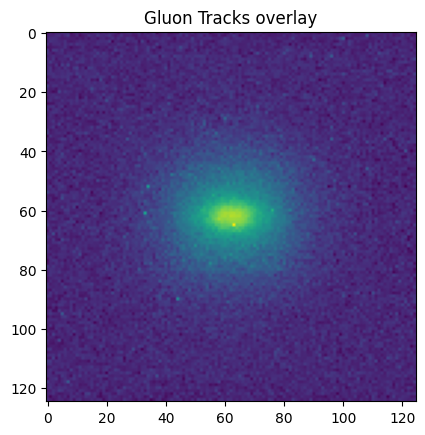

In [6]:
# Define a LogNorm for logarithmic scaling
norm = mcolors.LogNorm()

gluon_tracks_overlay = np.mean(jets_gluon[:,:,:,0], axis=0)
gluon_tracks_overlay = np.array(norm(gluon_tracks_overlay))

plt.imshow(gluon_tracks_overlay, cmap="viridis")
plt.title("Gluon Tracks overlay")
plt.show()

In [7]:
gluon_tracks_overlay.shape

(125, 125)

## **Batching and preprocessing**

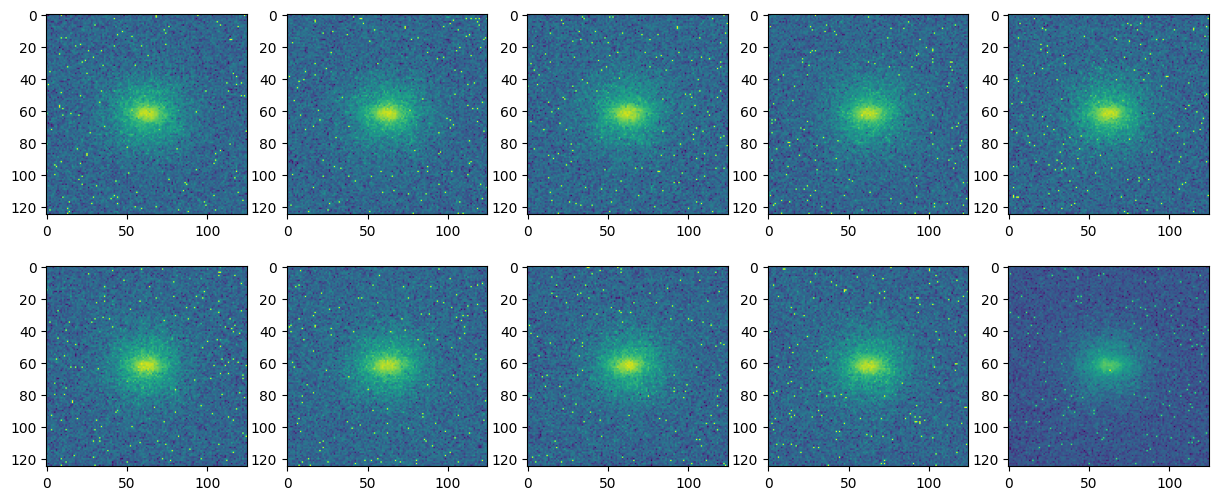

In [8]:
n_batches = 10
gluon_images = []

fig, axs = plt.subplots(2, 5, figsize=(15, 6)) 

for i in range(n_batches):
    row = i//5
    col = i%5 - 1
    gluon_tracks_overlay = np.mean(jets_gluon[i*1050:(i+1)*1050,:,:,0], axis=0)
    gluon_tracks_overlay = np.array(norm(gluon_tracks_overlay))
    gluon_images.append(gluon_tracks_overlay)
    axs[row, col].imshow(gluon_tracks_overlay, cmap="viridis")

gluon_images = np.array(gluon_images)

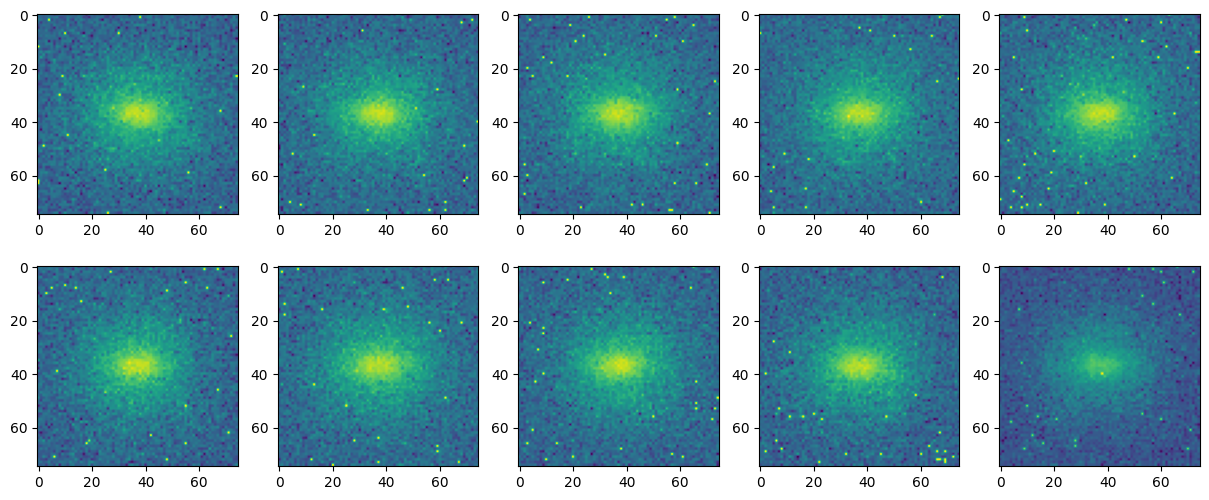

In [9]:
cropped_gluon_tracks_overlay = gluon_images[:,25:100, 25:100]

fig, axs = plt.subplots(2, 5, figsize=(15, 6)) 

for i in range(n_batches):
    row = i//5
    col = i%5 - 1
    axs[row, col].imshow(cropped_gluon_tracks_overlay[i], cmap="viridis")

gluon_images = np.array(gluon_images)

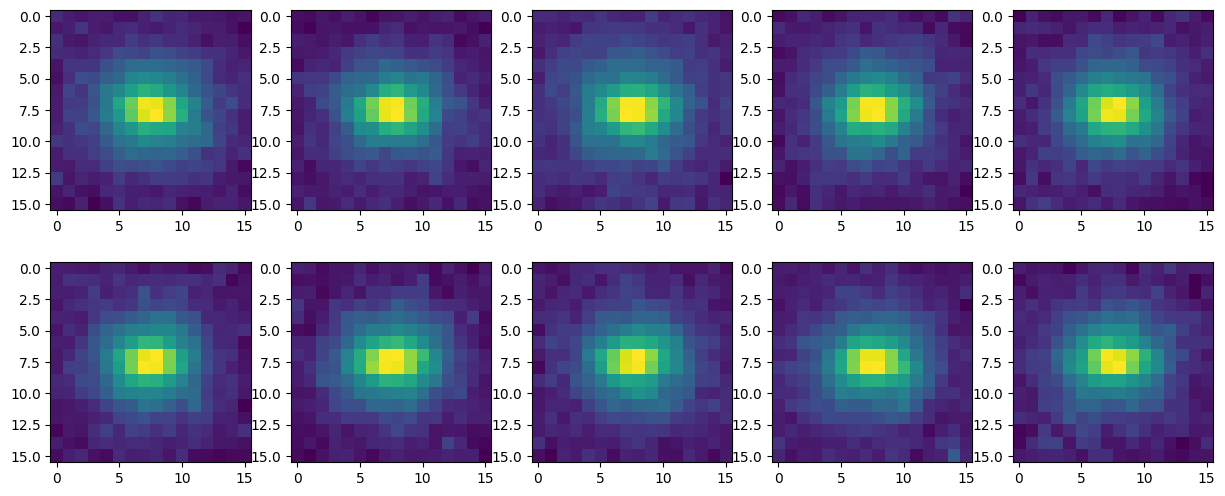

In [10]:
gluon_images_16x16 = []

fig, axs = plt.subplots(2, 5, figsize=(15, 6)) 

for i in range(n_batches):
    gluon = Image.fromarray(cropped_gluon_tracks_overlay[i])
    gluon_resized_tracks = gluon.resize((16, 16), Image.LANCZOS) # Resize
    gluon_resized_tracks = np.array(gluon_resized_tracks) # convert to numpy
    gluon_resized_tracks = gluon_resized_tracks/gluon_resized_tracks.sum() # normalize

    row = i//5
    col = i%5 - 1
    axs[row, col].imshow(gluon_resized_tracks, cmap="viridis")

    gluon_images_16x16.append(gluon_resized_tracks)

gluon_images_16x16 = np.array(gluon_images_16x16)

## **Training**

In [11]:
class Img_Dataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [12]:
# Create the data loader instance
dataset = Img_Dataset(gluon_images_16x16.reshape(10, 256))
dataloader = DataLoader(dataset, batch_size=1)

In [13]:
n_qubits = 11
a_qubits = 3
q_depth = 8 

In [14]:
# Discriminator implementation

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(256, 512),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(512, 64),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        
        return self.model(x)

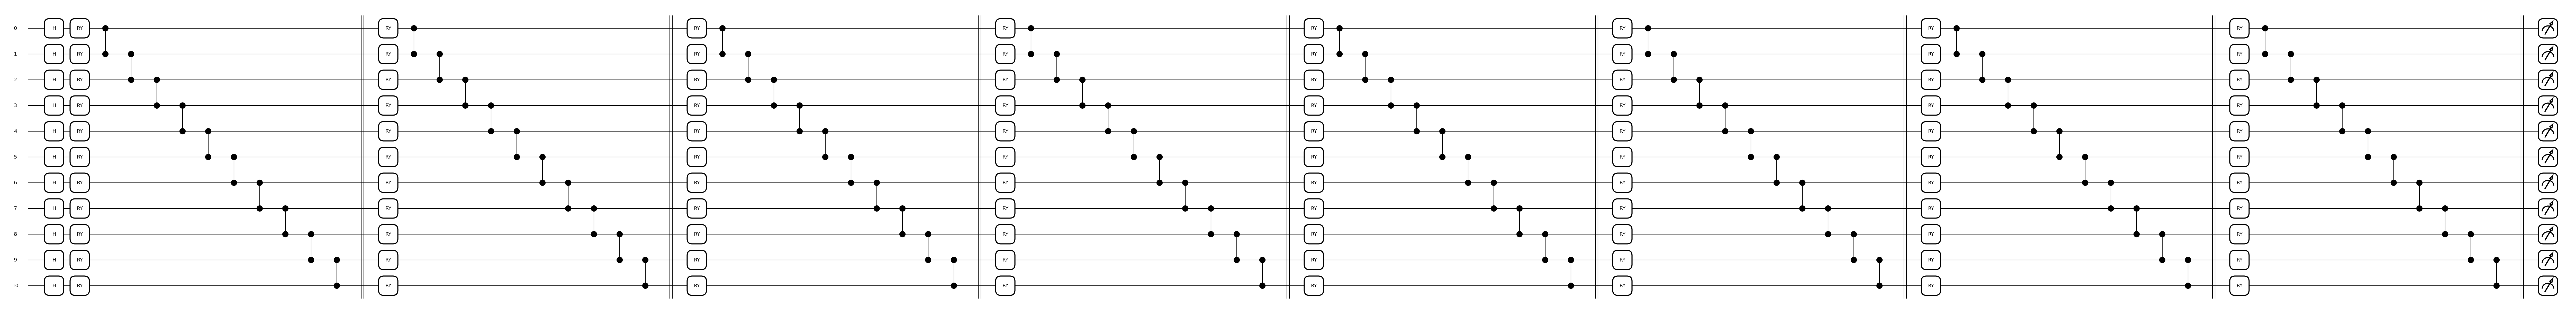

In [15]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))

noise = torch.rand(1, n_qubits, device=device) 
weights = torch.rand(1, n_qubits*q_depth) 

qml.draw_mpl(quantum_circuit)(weights=weights)
plt.show()

In [16]:
def partial_measure(qc, weights):
    # Non-linear Transform
    probs = qc(weights)
    probsgiven0 = probs[: (2 ** (n_qubits - a_qubits))]
    probsgiven0 /= torch.sum(probsgiven0)

    # Post-Processing
    #probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven0

In [17]:
class QuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.rand(q_depth * n_qubits), requires_grad=True)
            ]
        )

    def forward(self):

        qc_out = partial_measure(quantum_circuit, self.q_params[0]).float().unsqueeze(0)
        
        return qc_out
        

In [18]:
discriminator = Discriminator().to(device)
generator = QuantumGenerator().to(device)

In [19]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 2000  # Number of training iterations

In [20]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []
frenchet_d = []
kl_divergence = []
epochs = []

In [21]:
from scipy.linalg import sqrtm

def calculate_frechet_distance(real_data, generated_data):
    mu_r = np.mean(real_data, axis=0)
    mu_g = np.mean(generated_data, axis=0)
    C_r = np.cov(real_data, rowvar=False)
    C_g = np.cov(generated_data, rowvar=False)

    mean_diff = mu_r - mu_g
    cov_mean = sqrtm(C_r.dot(C_g))

    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    distance = mean_diff.dot(mean_diff) + np.trace(C_r + C_g - 2*cov_mean)
    return distance

In [22]:
from IPython.display import clear_output

def plot_training_progress(epoch):
    # we don't plot if we don't have enough data
    if len(frenchet_d) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

    # Frenchet distance
    ax1.set_title("Frenchet distance", fontsize=15)
    ax1.plot(epochs, frenchet_d, color="royalblue", linewidth=3)
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("FID")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy", fontsize=15)
    ax2.plot(epochs, kl_divergence)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    # Generated distribution
    t = generator().detach().numpy().reshape(16, 16)
    ax3.imshow(t.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
    ax3.set_title('Probability Distribution', fontsize=15)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')

    plt.suptitle(f"Epoch {epoch}", fontsize=25)
    plt.show()

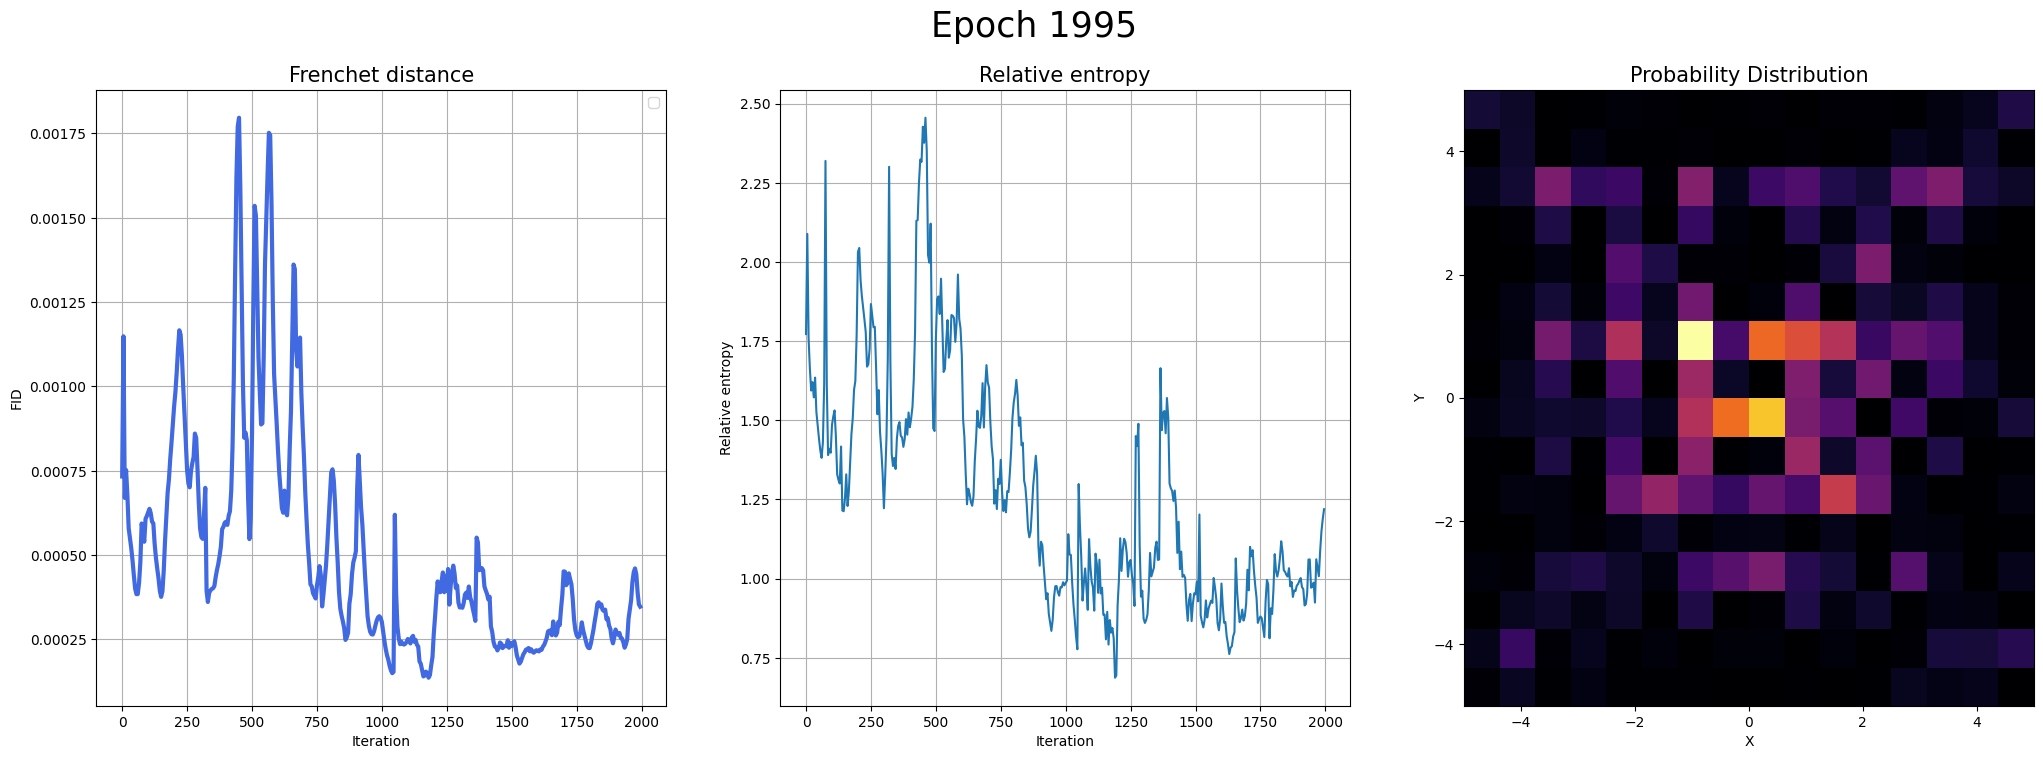

In [23]:
while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)
        fake_data = generator()

        # Calculate Frenchet Distance
        fd = calculate_frechet_distance(real_data.numpy().reshape(16, 16),fake_data.detach().numpy().reshape(16, 16))
        kl = np.sum(rel_entr(real_data.numpy().reshape(16, 16),fake_data.detach().numpy().reshape(16, 16))) 

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 5 == 0:
        #print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}, Frenchet Distance: {fd:0.6f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())
        frenchet_d.append(fd)
        kl_divergence.append(kl)
        epochs.append(counter)
        plot_training_progress(counter)

    counter += 1
    if counter == num_iter:
        break